## Preprocessing:

In [1]:
import numpy as np
import pandas as pd

student_data = pd.read_csv("student-data.csv")

# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels

# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "="*80
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))
print
print "-"*80
print("Features head:")
print X_all.head()


# Note,  I will also go ahead and convert the labels to a numeric value. 
# This will allow me to use a regression model if I desire to do so. 
y_all = preprocess_features(pd.DataFrame(y_all)) 
y_all = y_all['passed']
print
print "="*80
print "Value counts for 'passed':"
print y_all.value_counts()

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

--------------------------------------------------------------------------------
Features head:
   school_GP  school_MS  sex_F  sex_M  age  address_R  address_U  famsize_GT3  \
0          1          0      1      0   18          0          1            1   
1          1          0      1      0   17          0          1            1  

## Define function to fit and predict while reporting time benchmarks and F1 scores

In [2]:
import sklearn.cross_validation as cv
from sklearn import grid_search
from sklearn.metrics import f1_score, make_scorer
import time
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

ModelScores = namedtuple('ModelScores', 'num_samples fit_time predict_time f1_train f1_test')


def fit_predict(clf, Xdata, ydata, Xtest, ytest, verbose=True):
    """
    Uses Xdata and ydata to fit the classifier clf.  
    
    Reports F1 scores on both ydata nd ytest. 
    """
    
    start = time.time()
    clf.fit(Xdata, ydata)
    end = time.time()
    
    fit_time = end-start
    
    if verbose:
        print
        print "="*80
        print "Model training time (secs): {:.3f}".format(fit_time)

    # Predict on training set and compute f1score
    start = time.time()
    y_pred = clf.predict(Xdata)
    end = time.time()
    f1_train = f1_score(ydata, y_pred)
    
    if verbose:
        print
        print "Model prediction time [train set] (secs): {:.3f}".format(end-start)
        print "F1 score for train set: {}".format(f1_train)

    # Predict on test set and compute f1score
    start = time.time()
    y_pred = clf.predict(Xtest)
    end = time.time()
    predict_time = end-start
    f1_test = f1_score(ytest, y_pred)
    
    if verbose: 
        print
        print "Model prediction time [test set] (secs): {:.3f}".format(predict_time)
        print "F1 score for test set: {}".format(f1_test)
        
    fit_samples = len(Xdata)
    return ModelScores(fit_samples, fit_time, predict_time, f1_train, f1_test)

## Also define a generalized student intervention class that will handle the data and models

In [41]:

class Intervention:
    """
    The student intervention class. 
    
    This class is initialized with a set of X, y data that will be used
    to develop a model for the student intervention system. 
    
    300 samples of the data will be chosen at random and will be used 
    in training the model.   The rest of the data will be used for 
    testing. 
       
    """
    
    def __init__(self, X, y):
        
        # 300 training samples (95 samples are kept for testing.)
        num_train = 300
        self.Xtr, self.Xts, self.ytr, self.yts = cv.train_test_split(
            X, y, train_size=num_train, random_state=40, stratify=y)
        
        # We calculate the test set f1score for an all-passing prediction:
        self.ones_f1score = f1_score(self.yts, np.ones_like(self.yts))
        
        print "F1 score if predict all passing: ", self.ones_f1score
        
    
    def classifier_learning_curve(self, clf, **clf_kwargs):
        """
        This function will be used to fit a classifier and then score it 
        according to a series of metrics as described below.
        
        The model variance will be assesed using 3-Fold cross-validation
        on the training set. 
        
        The prediction performance will be assesed using validation on 
        the test set, with a model fitted using the entire training set.
        
        The time performance for fitting will be assesed by fitting on the 
        entire training set. 
        
        The time performance for predicting will be assessed when generating
        predicitons for the test set. 
        
        Parameters
        ----------
        
        clf : sklearn-like classifier (has .fit() and .predict() methods)
        
        clf_kwargs : dict
        
            dictionary of kwargs that will be passed on to initalize the 
            classifier.
        
        """
        
        best = clf_kwargs.pop('best', False)
        
        clf = clf(**clf_kwargs)
        
        results_list = []
        
        # Train on variable sized set, and collect results for all train sizes.
        for size in np.linspace(0.02, 0.95, 25):
            try:
                # Repeat 3 times. Each time a different random train_test_split will be generated.
                for i in range(3):
                    X1, _, y1, _ = cv.train_test_split(self.Xtr, self.ytr, train_size=size)
                    results_list.append(fit_predict(clf, X1, y1, self.Xts, self.yts, verbose=False))
            except:
                pass
            
        # Start out a results_list, with the results of fitting on the entire training set. 
        results_list.append(fit_predict(clf, self.Xtr, self.ytr, self.Xts, self.yts, verbose=False))
        
        results_df = pd.DataFrame(results_list)
        
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        
        ax[0].plot(results_df.num_samples, results_df.f1_train, '.', color='blue', label='train')
        ax[0].plot(results_df.num_samples, results_df.f1_test, '.', color='green', label='test')
        
        ax[1].plot(results_df.num_samples, results_df.fit_time, '.', color='blue', label='fit')
        ax[1].plot(results_df.num_samples, results_df.predict_time, '.', color='green', label='predict')
        
        ax[0].set_ylabel('F1 Score')
        ax[1].set_ylabel('time (seconds)')
        
        ax[0].set_xlabel('training samples')
        ax[1].set_xlabel('training samples')
        
        ax[0].legend(loc='lower right', bbox_to_anchor=(1.0, 1.01), ncol=2, prop={'size':9})
        ax[1].legend(loc='lower right', bbox_to_anchor=(1.0, 1.01), ncol=2, prop={'size':9})
        
        ax[0].set_ylim(0.5, 1.05)
        ax[1].set_ylim(0., 0.01)
        
        ax[0].text(0.02, 0.02, '* gray line is F1 score for\npredicting all as passing',
                   transform=ax[0].transAxes,
                   ha='left', va='bottom', fontsize=9)
        ax[0].axhline(self.ones_f1score, color='black', alpha=0.5, lw=1.5)
        
        fig.suptitle(str(clf.__class__))
        fig.tight_layout(rect = [0.02, 0.02, 0.98, 0.90])
        
        if best:
            ext = '_best.png'
        else:
            ext = '.png'
        figname = 'figures/' + str(clf.__class__).strip("'>").split('.')[-1] + ext
        fig.savefig(figname, dpi=150)
        
        return results_df
    
    
    def classifier_gridsearch(self, clf, param_grid):
        """
        This function takes the training data and uses it to perform a parameter 
        grid search with 3-Fold cross validation and using the f1_score as metric.
        
        The best estimator in the grid search is used to make predictions over the
        entire training set and over the test set.  The F1 score of those predictions
        is reported on screen. 
        
        The individual f1 scores of each of the points in the parameter grid is 
        reported as a dataframe that is returned by this function.       
        
        """
        
        cv_folds = cv.StratifiedKFold(self.ytr, n_folds=3, shuffle=True, random_state=42)
        
        gridclf = grid_search.GridSearchCV(clf(), param_grid,
                                           scoring=make_scorer(f1_score),
                                           cv=cv_folds,
                                           refit=True)
        
        
        gridclf.fit(self.Xtr, self.ytr)
        
        self.best = gridclf.best_estimator_
        
        best_pred_tr = self.best.predict(self.Xtr)
        best_pred_ts = self.best.predict(self.Xts)
        f1_score_tr = f1_score(best_pred_tr, self.ytr)
        f1_score_ts = f1_score(best_pred_ts, self.yts)
        print "F1 Score train : {:.3f}".format(f1_score_tr)
        print "F1 Score test  : {:.3f}".format(f1_score_ts)
        
        
        results = []
        for result in gridclf.grid_scores_:
            dictout = result.parameters
            
            estimator = clf(**dictout)
            
            start = time.time()
            estimator.fit(self.Xtr, self.ytr)
            end = time.time()
            dictout['fit_time'] = end - start
            
            start = time.time()
            pred_ts = estimator.predict(self.Xts)
            end = time.time()
            dictout['predict_time'] = end - start
            
            dictout['test_score'] = f1_score(pred_ts, self.yts)
            dictout['mean_score'] = result.mean_validation_score
            
            # Here I will store number of yes/no predictions for the test set
            dictout['pred_yes'] = pred_ts.sum()
            dictout['pred_no'] = -1.*(pred_ts-1).sum() 
            
            assert len(pred_ts) == dictout['pred_yes'] + dictout['pred_no']
            results.append(dictout)

        
        grid_search_df = pd.DataFrame(results)
        grid_search_df['index'] = grid_search_df.index
        
        return grid_search_df

## Feed different models to the Intervention class, and plot learning curves using the default model parameters

F1 score if predict all passing:  0.805031446541


/home/pmd/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


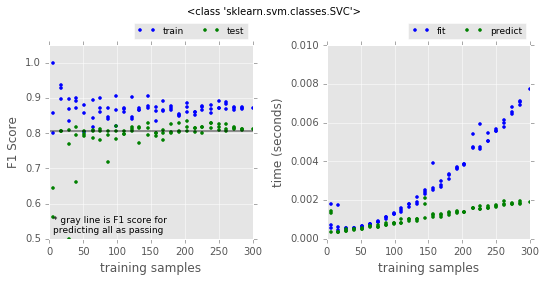

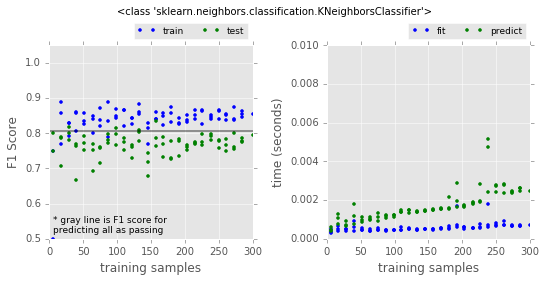

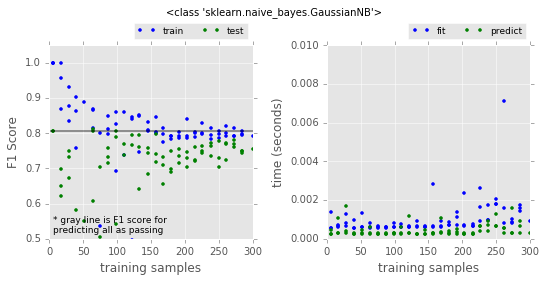

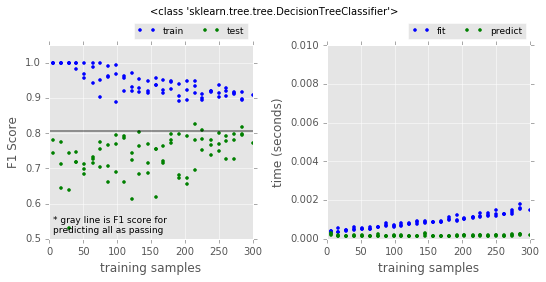

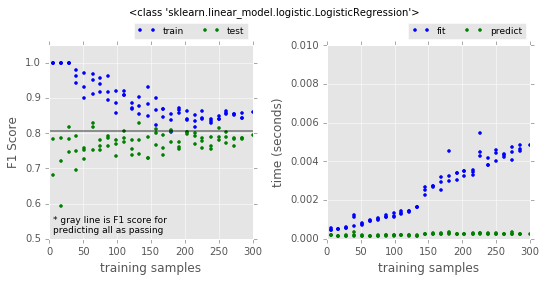

In [27]:
interv = Intervention(X_all, y_all)

from sklearn import svm
df = interv.classifier_learning_curve(svm.SVC)

from sklearn.neighbors import KNeighborsClassifier
df = interv.classifier_learning_curve(KNeighborsClassifier, n_neighbors=5)

from sklearn.naive_bayes import GaussianNB
df = interv.classifier_learning_curve(GaussianNB)

from sklearn import tree
df = interv.classifier_learning_curve(tree.DecisionTreeClassifier, max_depth=6)

from sklearn import linear_model
df = interv.classifier_learning_curve(linear_model.LogisticRegression)

# 5. Choosing the best model

We start out by defining an interactive plot to visualize the results of a parameter grid search:

In [5]:
from bokeh.io import output_notebook, show
output_notebook()

from bokeh.plotting import figure
from bokeh.io import gridplot
from bokeh.models import ColumnDataSource, Span
from bokeh.models import HoverTool, ResetTool, PanTool

def make_tooltip_plot(df, ones_f1score, xcol, ycol1, ycol2, title):
    source = ColumnDataSource(df)
    hover = HoverTool(tooltips = [(col, "@{:s}".format(col)) for col in df.columns])
    p = figure(plot_width=600, plot_height=400, tools=[hover, PanTool()], title=title,
              x_axis_label = xcol, y_axis_label = "F1 Score")
    p.title_text_font_size = "10pt"
    p.xaxis.axis_label_text_font_size = "10pt"
    p.yaxis.axis_label_text_font_size = "10pt"
    
    p.circle(xcol, ycol1, size=10, color='blue', alpha=0.5, source=source, legend=ycol1)
    p.circle(xcol, ycol2, size=10, color='green', alpha=0.5, source=source, legend=ycol2)
    
    hspan = Span(location=ones_f1score, dimension='width',
                 line_color='black', line_width=3, line_alpha=0.3)
    p.renderers.extend([hspan])
    
    show(gridplot([[p]]))
    

Loading BokehJS ...

## 5a. SVC

We run a grid search on the `kernel`, `C` and `gamma` parameters for the SVC.  We use as a metric the F1_Score on the test set, and obtain that a good set of values for the parameters is:

* `kernel` = `linear`
* `C` = 1
* `gamma` = 0.01

In [62]:
interv = Intervention(X_all, y_all)

from sklearn import svm
df = interv.classifier_gridsearch(svm.SVC, {
        'kernel':('linear', 'rbf'),
        'C':[0.2, 1, 2], 
        'gamma': ['auto', 0.1, 0.04, 0.02, 0.01, 0.008, 0.005]})

make_tooltip_plot(df, interv.ones_f1score, xcol='index', ycol1='mean_score', ycol2='test_score', title='SVC')
df.sort_values(by='test_score', ascending=False)[['kernel', 'C', 'gamma', 'pred_yes', 'pred_no', 'test_score', 'mean_score']]

F1 score if predict all passing:  0.805031446541
F1 Score train : 0.998
F1 Score test  : 0.779


,kernel,C,gamma,pred_yes,pred_no,test_score,mean_score
23,rbf,1.0,0.01,84,11,0.824324,0.808301
19,rbf,1.0,0.04,85,10,0.818792,0.807397
41,rbf,2.0,0.005,83,12,0.816327,0.808412
25,rbf,1.0,0.008,86,9,0.813333,0.803274
17,rbf,1.0,0.1,91,4,0.812903,0.810570
15,rbf,1.0,auto,84,11,0.810811,0.803378
21,rbf,1.0,0.02,84,11,0.810811,0.805039
27,rbf,1.0,0.005,89,6,0.810458,0.798305
7,rbf,0.2,0.02,95,-0,0.805031,0.802395
9,rbf,0.2,0.01,95,-0,0.805031,0.802395


F1 score if predict all passing:  0.805031446541


,num_samples,fit_time,predict_time,f1_train,f1_test
75,300,0.00726,0.001888,0.841438,0.824324


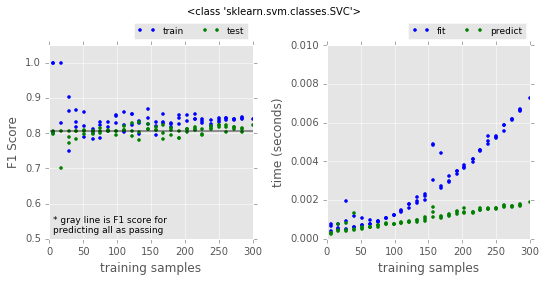

In [61]:
from sklearn import svm
params = {
    'kernel': 'rbf',
    'C': 1,
    'gamma': 0.01,
    'best': True
}
interv = Intervention(X_all, y_all)
df = interv.classifier_learning_curve(svm.SVC, **params)

df[df['num_samples'] == 300]

## 5b. KNN

In [49]:
interv = Intervention(X_all, y_all)

from sklearn.neighbors import KNeighborsClassifier
df = interv.classifier_gridsearch(KNeighborsClassifier, {
        'n_neighbors': (1, 2, 4, 8, 16, 32, 64, 128, 150),
        'weights': ('uniform',)})

make_tooltip_plot(df, interv.ones_f1score, xcol='index', ycol1='mean_score', ycol2='test_score', title='KNN')
df.sort_values(by='test_score', ascending=False)

F1 score if predict all passing:  0.805031446541
F1 Score train : 0.802
F1 Score test  : 0.805


,fit_time,mean_score,n_neighbors,pred_no,pred_yes,predict_time,test_score,weights,index
5,0.001229,0.798359,32,9,86,0.005579,0.813333,uniform,5
6,0.001238,0.802395,64,-0,95,0.008090,0.805031,uniform,6
7,0.000743,0.802395,128,-0,95,0.009071,0.805031,uniform,7
8,0.000404,0.802395,150,-0,95,0.002331,0.805031,uniform,8
4,0.000950,0.785746,16,15,80,0.003672,0.777778,uniform,4
2,0.000736,0.722828,4,25,70,0.002586,0.761194,uniform,2
3,0.000772,0.775158,8,22,73,0.002897,0.759124,uniform,3
0,0.000787,0.725784,1,27,68,0.002400,0.727273,uniform,0
1,0.000788,0.660670,2,44,51,0.002447,0.643478,uniform,1


F1 score if predict all passing:  0.805031446541


,num_samples,fit_time,predict_time,f1_train,f1_test
66,300,0.00063,0.002777,0.804928,0.813333


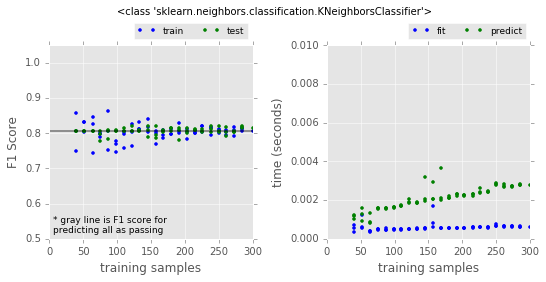

In [60]:
from sklearn.neighbors import KNeighborsClassifier
params = {
    'n_neighbors': 32,
    'weights': 'uniform',
    'best': True
}
interv = Intervention(X_all, y_all)
df = interv.classifier_learning_curve(KNeighborsClassifier, **params)

df[df['num_samples'] == 300]

## 5c. Decision Tree Classifier

In [56]:
interv = Intervention(X_all, y_all)

from sklearn import tree
df = interv.classifier_gridsearch(tree.DecisionTreeClassifier, {
          'max_features': (12, 18, 24, 30),
          'max_depth' : (3, 4, 5, 6),
          'min_samples_split' : (2, 4, 8),
          'min_samples_leaf' : (1, 2, 4),
          'random_state': (42,),
          'presort': (True,)
         })


make_tooltip_plot(df, interv.ones_f1score, xcol='index', ycol1='mean_score', ycol2='test_score', title='Decision Tree')
df.sort_values(by='test_score', ascending=False)

F1 score if predict all passing:  0.805031446541
F1 Score train : 0.844
F1 Score test  : 0.779


,fit_time,max_depth,max_features,mean_score,min_samples_leaf,min_samples_split,pred_no,pred_yes,predict_time,presort,random_state,test_score,index
65,0.001147,4,30,0.786473,1,8,20,75,0.000163,True,42,0.834532,65
69,0.001149,4,30,0.784080,4,2,22,73,0.000164,True,42,0.832117,69
70,0.001158,4,30,0.784080,4,4,22,73,0.000164,True,42,0.832117,70
71,0.001105,4,30,0.784080,4,8,22,73,0.000170,True,42,0.832117,71
77,0.000872,5,12,0.742623,2,8,17,78,0.000155,True,42,0.830986,77
68,0.001138,4,30,0.786699,2,8,21,74,0.000157,True,42,0.826087,68
81,0.000991,5,18,0.760903,1,2,21,74,0.000154,True,42,0.826087,81
9,0.001085,3,18,0.756855,1,2,21,74,0.000277,True,42,0.826087,9
10,0.001003,3,18,0.756855,1,4,21,74,0.000255,True,42,0.826087,10
11,0.001132,3,18,0.756855,1,8,21,74,0.000279,True,42,0.826087,11


F1 score if predict all passing:  0.805031446541


,num_samples,fit_time,predict_time,f1_train,f1_test
75,300,0.000809,0.000163,0.852535,0.834532


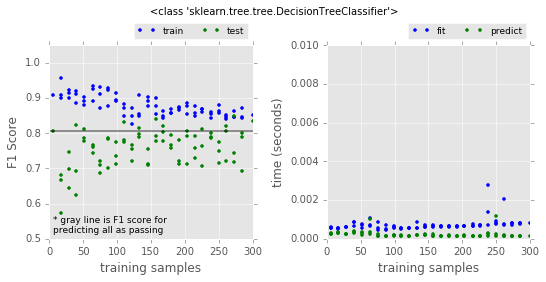

In [59]:
from sklearn import tree
params = {
    'max_features': 30,
    'max_depth': 4,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'random_state': 42,
    'best': True
}
interv = Intervention(X_all, y_all)
df = interv.classifier_learning_curve(tree.DecisionTreeClassifier, **params)

df[df['num_samples'] == 300]